In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

## Importing data

In [2]:
# df = pd.read_csv('ec2_cpu_utilization_24ae8d.csv')
df = pd.read_csv('data/cpu_utilization_asg_misconfiguration.csv')
max_points = 1000
df = df[:max_points]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = df['value']
df.head()

,timestamp,value
0,2014-05-14 01:14:00,85.835
1,2014-05-14 01:19:00,88.167
2,2014-05-14 01:24:00,44.595
3,2014-05-14 01:29:00,56.282
4,2014-05-14 01:34:00,36.534


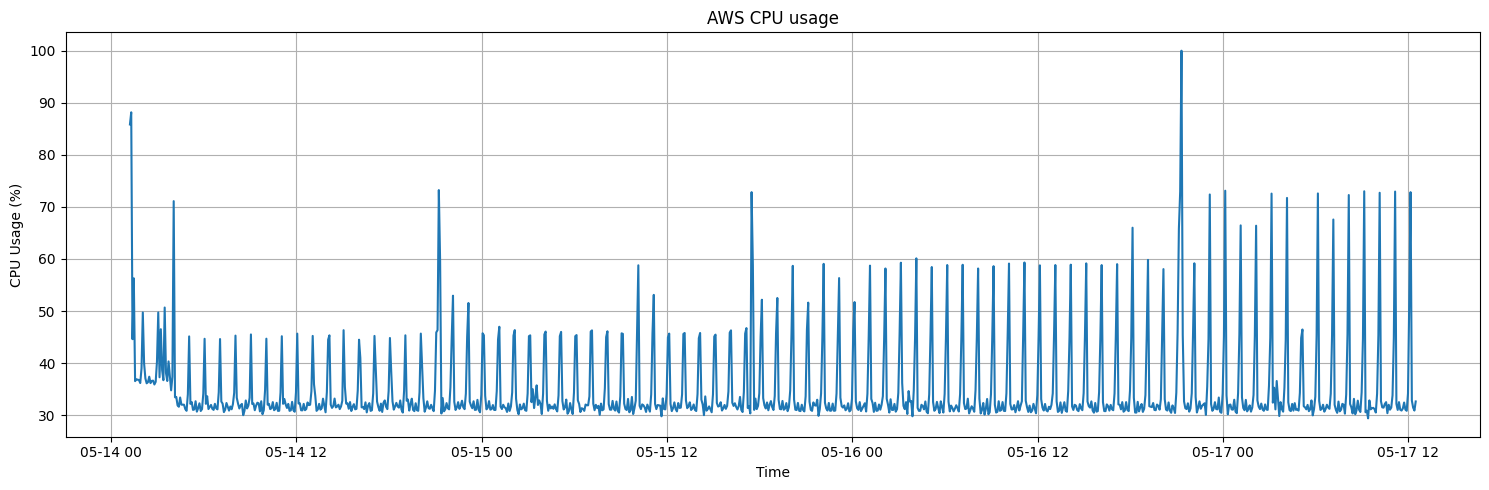

In [3]:

fig, axs = plt.subplots(1, figsize=(15,5))
axs.plot(df['timestamp'][:max_points], df['value'][:max_points], label='Component 1')
axs.set_xlabel('Time')
axs.set_ylabel('CPU Usage (%)')
axs.set_title('AWS CPU usage')
axs.grid(True)

plt.tight_layout()
plt.show()

## Modeling

### Statistical methods

#### Median Absolute Deviation (MAD)

In [4]:
median = df['value'].median()
df['abs_dev'] = abs(df['value'] - median)
mad = df['abs_dev'].median()
print(f'MAD = {round(mad, 4)}')
threshold = 3*mad
print(f'threshold = {round(threshold, 4)}')
df['is_anomaly'] = df['abs_dev'].apply(lambda x: x>=threshold)
df['is_anomaly'].value_counts()

MAD = 1.053
threshold = 3.159


is_anomaly
False    799
True     201
Name: count, dtype: int64

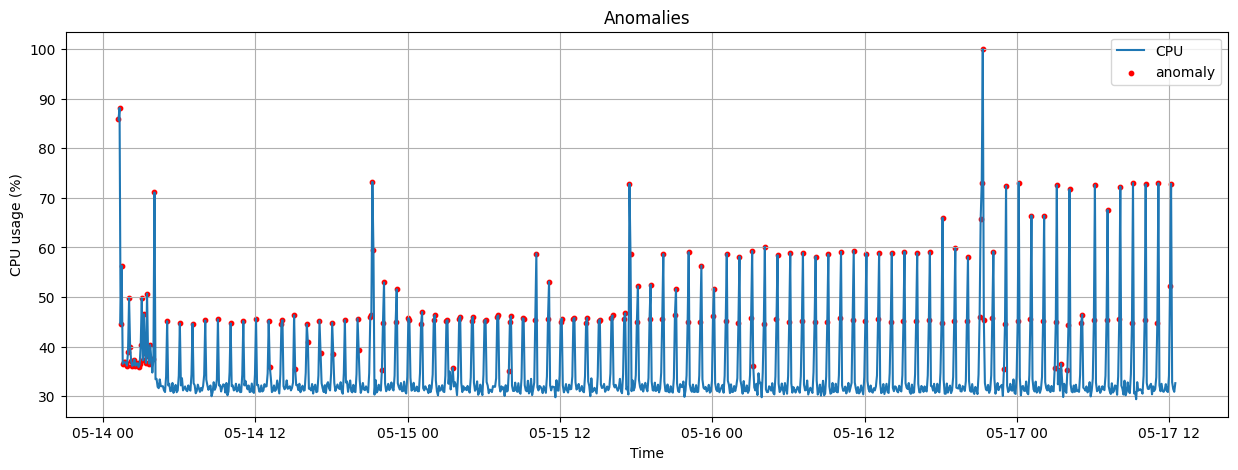

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df['is_anomaly'], 'timestamp'], 
            y = df.loc[df['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

#### Z-score

In [6]:
mean = df['value'].mean()
std_dev = df['value'].std()
print(f'mean = {mean}')
print(f'std_dev = {round(std_dev, 4)}')
df['z_score'] = (df['value'] - mean) / std_dev
threshold = 3
df['is_anomaly'] = df['z_score'].apply(lambda x: abs(x) >= threshold)
df['is_anomaly'].value_counts()

mean = 35.2626
std_dev = 8.538


is_anomaly
False    978
True      22
Name: count, dtype: int64

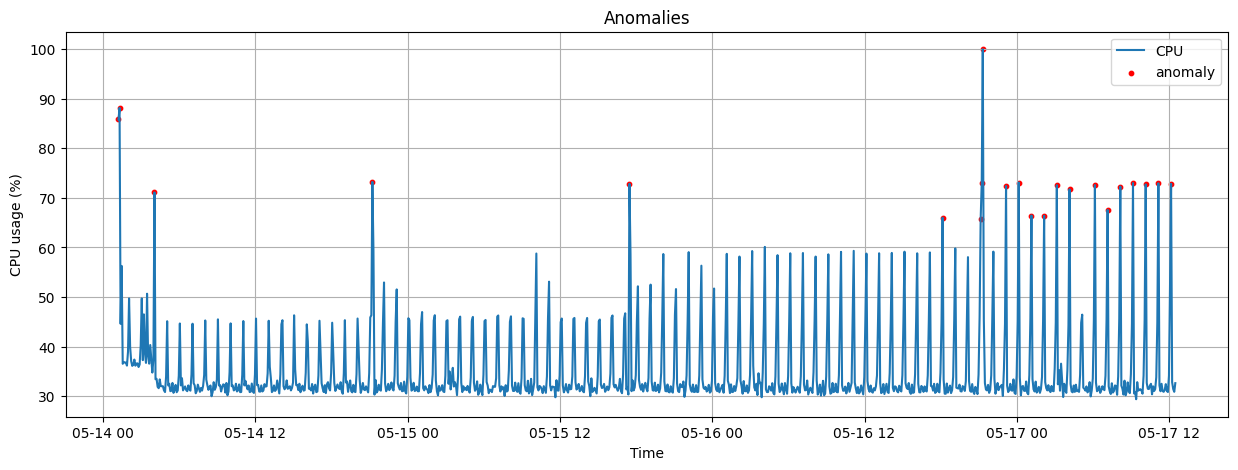

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df['is_anomaly'], 'timestamp'], 
            y = df.loc[df['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

### ML Models

#### Isolation forest

In [8]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest()
isf.fit(df.loc[:, ['value']])
df['is_anomaly'] = isf.predict(df.loc[:, ['value']]) == -1
df['is_anomaly'].value_counts()

is_anomaly
False    817
True     183
Name: count, dtype: int64

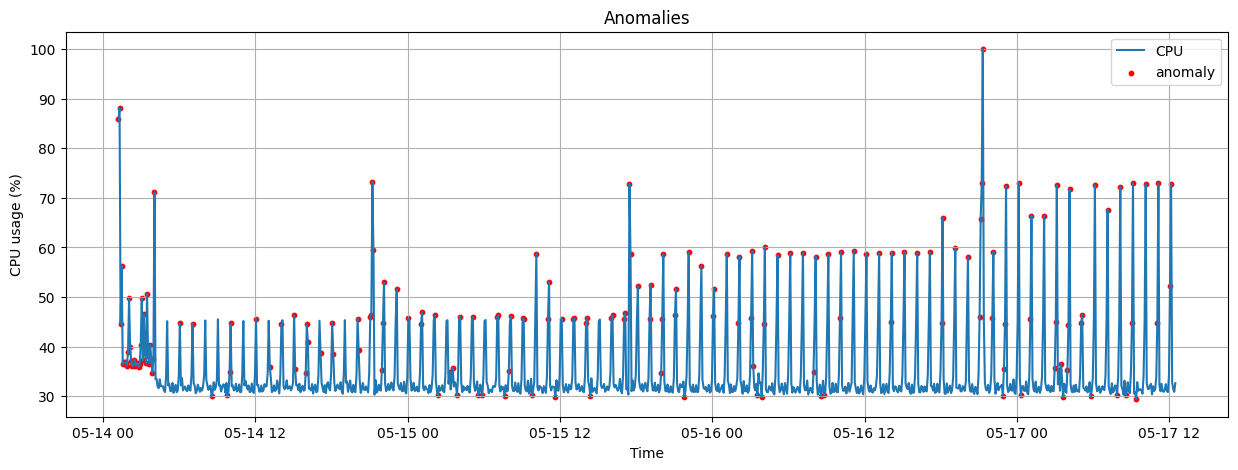

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df['is_anomaly'], 'timestamp'], 
            y = df.loc[df['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

#### Local Outlier Factor

In [10]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
df['is_anomaly'] = lof.fit_predict(df.loc[:, ['value']]) == -1
df['is_anomaly'].value_counts()

is_anomaly
False    903
True      97
Name: count, dtype: int64

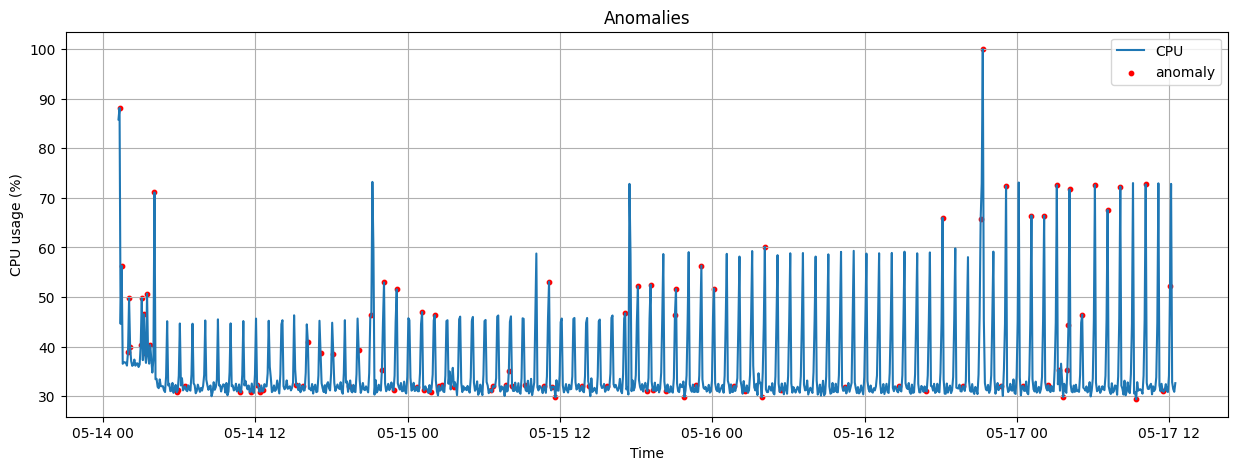

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df['is_anomaly'], 'timestamp'], 
            y = df.loc[df['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

### STL Decomposition

In [12]:
acf = sm.tsa.stattools.acf(df['value'], nlags=40)
for i_lag, lag_acf in enumerate(acf):
    print(f'Lag {i_lag}, ACF = {lag_acf}')

Lag 0, ACF = 1.0
Lag 1, ACF = 0.3923705251717204
Lag 2, ACF = -0.003567904145149895
Lag 3, ACF = -0.12890341732179836
Lag 4, ACF = -0.12082757073488566
Lag 5, ACF = -0.11969006400181945
Lag 6, ACF = -0.15673084520694133
Lag 7, ACF = -0.11306814902495216
Lag 8, ACF = -0.11393102619315967
Lag 9, ACF = -0.13419136574860507
Lag 10, ACF = -0.024051526765664976
Lag 11, ACF = 0.25958486874030057
Lag 12, ACF = 0.7111138386055217
Lag 13, ACF = 0.2523960304517522
Lag 14, ACF = -0.0439925858295851
Lag 15, ACF = -0.15074939646682406
Lag 16, ACF = -0.12594740314112626
Lag 17, ACF = -0.12266413581469056
Lag 18, ACF = -0.15814344249963103
Lag 19, ACF = -0.11876759015336505
Lag 20, ACF = -0.11510069496209277
Lag 21, ACF = -0.13335627728758576
Lag 22, ACF = -0.020850150809270884
Lag 23, ACF = 0.26242706111922065
Lag 24, ACF = 0.7052858088511748
Lag 25, ACF = 0.2494794600941046
Lag 26, ACF = -0.038262991904140974
Lag 27, ACF = -0.14078765833061288
Lag 28, ACF = -0.12796032413911732
Lag 29, ACF = -0.1236

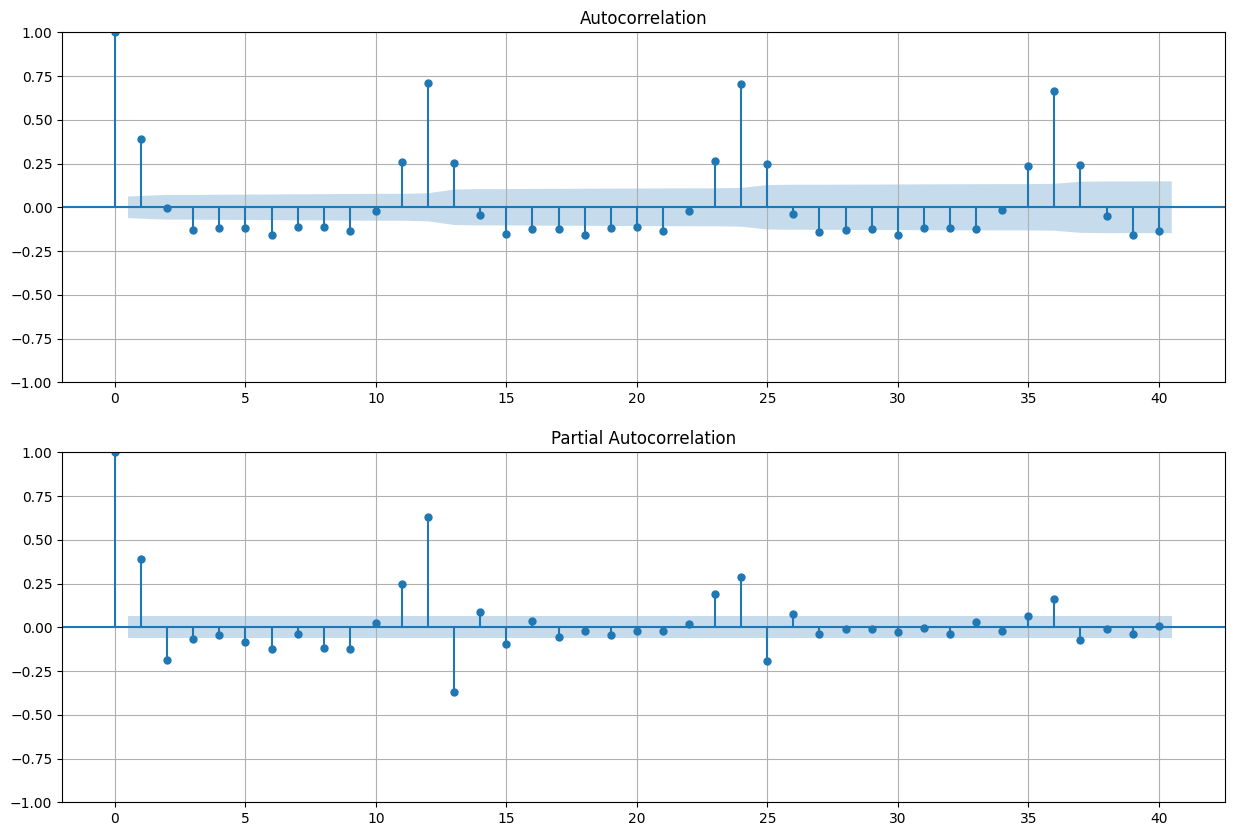

In [13]:
fig, axs = plt.subplots(2, figsize=(15, 10))

sm.graphics.tsa.plot_acf(df['value'], lags=40, ax=axs[0], use_vlines=True);
sm.graphics.tsa.plot_pacf(df['value'], lags=40, ax=axs[1], use_vlines=True);
axs[0].grid(True)
axs[1].grid(True)
plt.show()

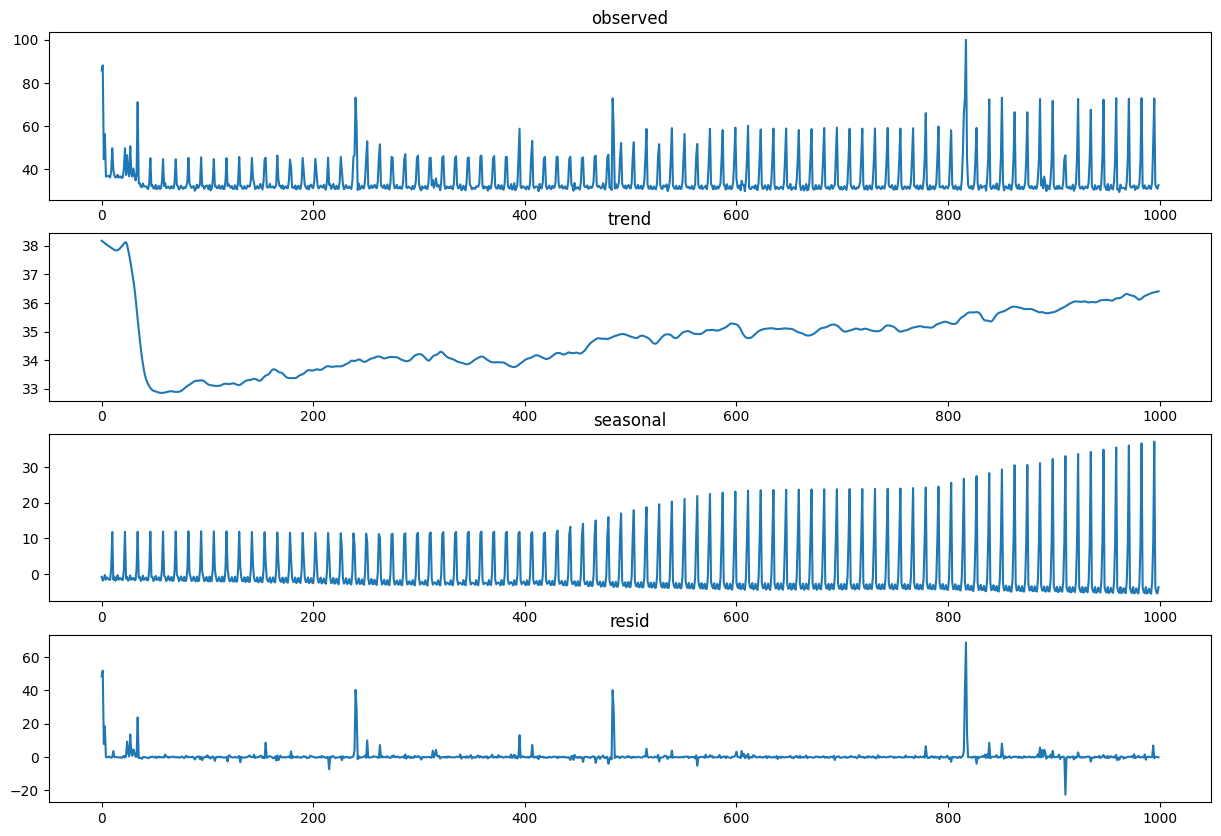

In [14]:
from statsmodels.tsa.seasonal import STL

comps = ['observed', 'trend', 'seasonal', 'resid']

stl = STL(df['value'], period=12, seasonal=13, robust=True)
res = stl.fit()

fig, axs = plt.subplots(4, figsize=(15, 10))
for ax, comp in zip(axs, comps):
    series = getattr(res, comp)
    ax.plot(series)
    ax.set_title(comp)
plt.show()

In [15]:
df_resid = pd.DataFrame({'timestamp': df['timestamp'],
                        'residuals': res.resid})
df_resid.head()

,timestamp,residuals
0,2014-05-14 01:14:00,48.468025
1,2014-05-14 01:19:00,51.890333
2,2014-05-14 01:24:00,7.864467
3,2014-05-14 01:29:00,18.473754
4,2014-05-14 01:34:00,0.074013


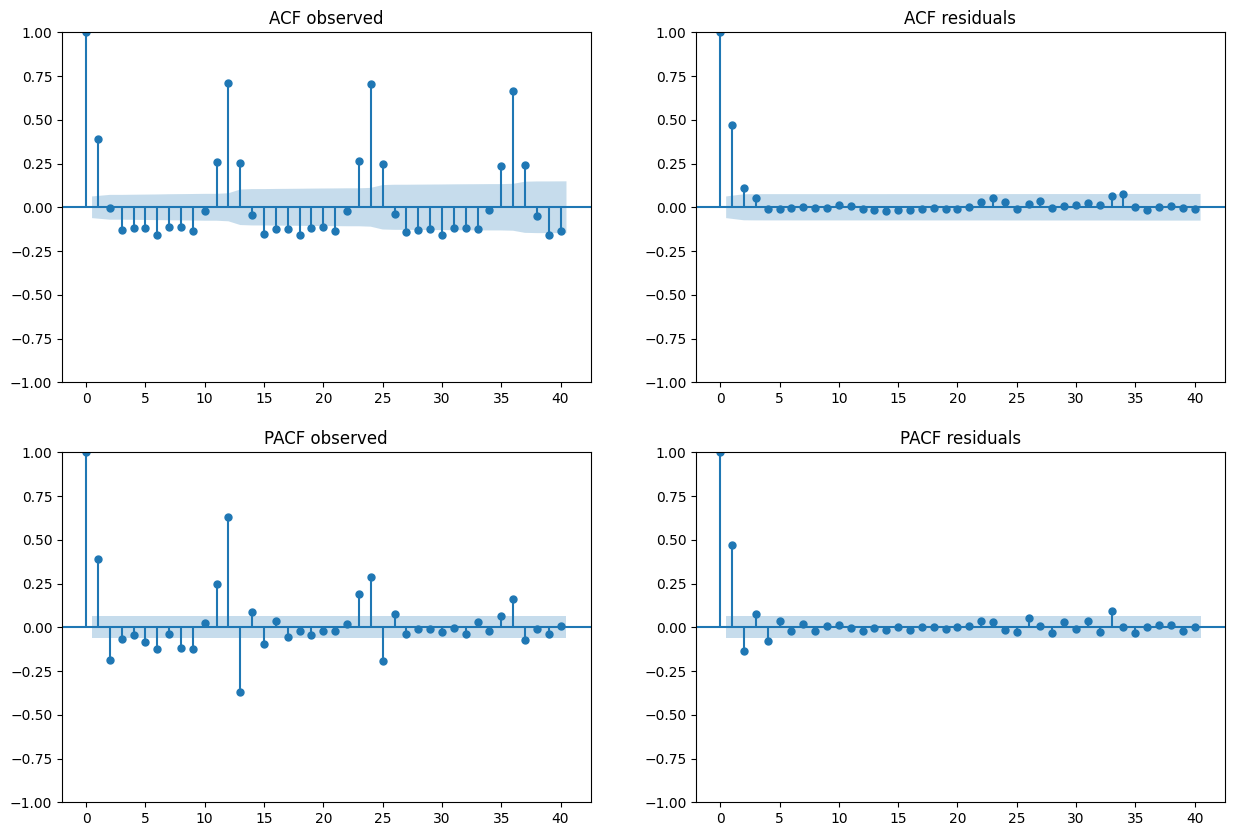

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sm.graphics.tsa.plot_acf(df['value'], lags=40, ax=axs[0][0], use_vlines=True);
axs[0][0].set_title('ACF observed')
sm.graphics.tsa.plot_pacf(df['value'], lags=40, ax=axs[1][0], use_vlines=True);
axs[1][0].set_title('PACF observed')

sm.graphics.tsa.plot_acf(df_resid['residuals'], lags=40, ax=axs[0][1], use_vlines=True);
axs[0][1].set_title('ACF residuals')
sm.graphics.tsa.plot_pacf(df_resid['residuals'], lags=40, ax=axs[1][1], use_vlines=True);
axs[1][1].set_title('PACF residuals')
plt.show()

#### Median Absolute Deviation (MAD)

In [17]:
median = df_resid['residuals'].median()
df_resid['abs_dev'] = abs(df_resid['residuals'] - median)
mad = df_resid['abs_dev'].median()
print(f'MAD = {round(mad, 4)}')
threshold = 3*mad
print(f'threshold = {round(threshold, 4)}')
df_resid['is_anomaly'] = df_resid['abs_dev'].apply(lambda x: x>=threshold)
df_resid['is_anomaly'].value_counts()

MAD = 0.2516
threshold = 0.7549


is_anomaly
False    844
True     156
Name: count, dtype: int64

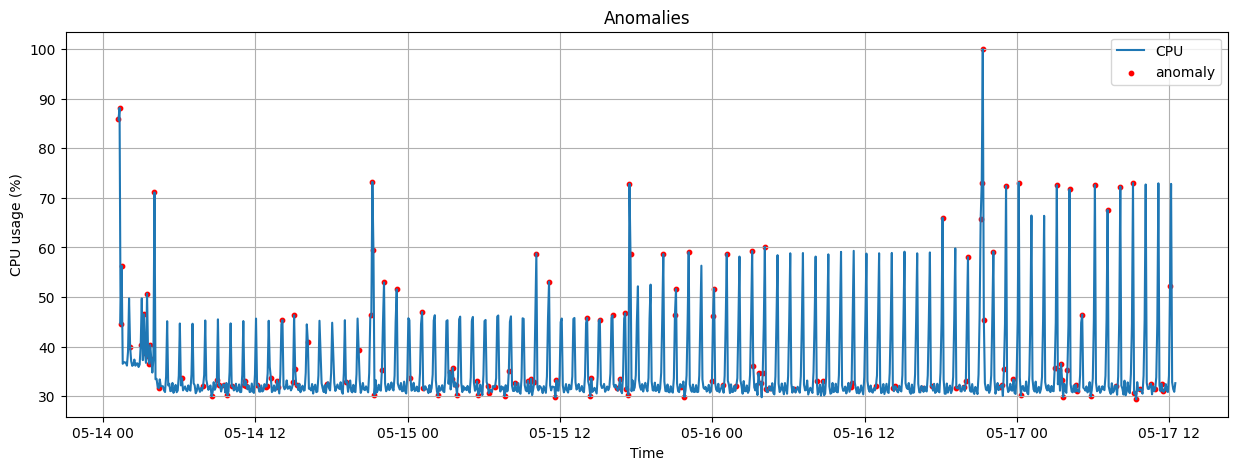

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df_resid['is_anomaly'], 'timestamp'], 
            y = df.loc[df_resid['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

#### Z-score

In [19]:
mean = df_resid['residuals'].mean()
std_dev = df_resid['residuals'].std()
print(f'mean = {round(mean, 4)}')
print(f'std dev = {round(std_dev, 4)}')
df_resid['z_score'] = (df_resid['residuals'] - mean) / std_dev
threshold = 3
df_resid['is_anomaly'] = df['z_score'].apply(lambda x: x >= threshold)
df_resid['is_anomaly'].value_counts()

mean = 0.5346
std dev = 4.386


is_anomaly
False    978
True      22
Name: count, dtype: int64

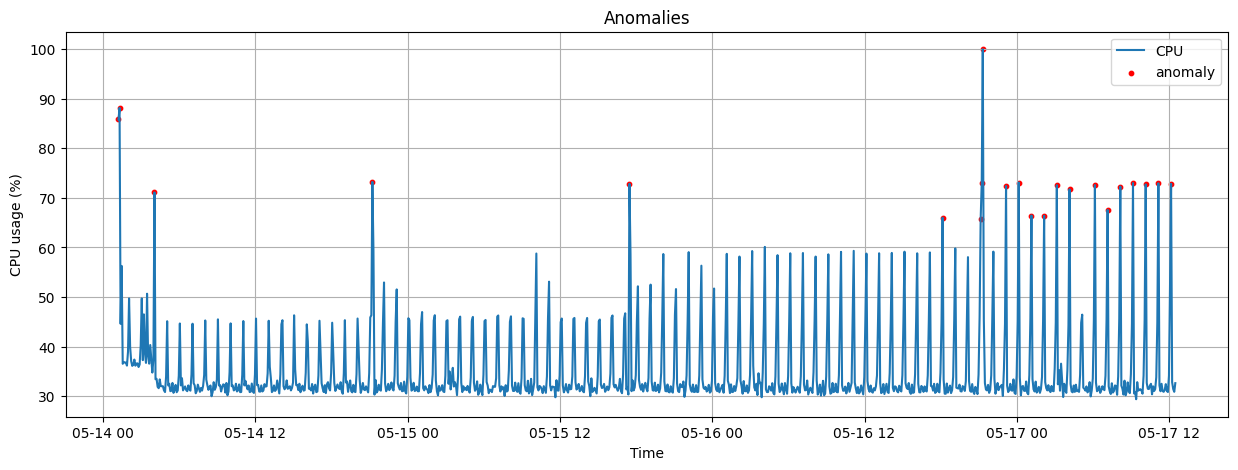

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df_resid['is_anomaly'], 'timestamp'], 
            y = df.loc[df_resid['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

#### Isolation Forest

In [21]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest()
isf.fit(df_resid.loc[:, ['residuals']])
df_resid['is_anomaly'] = isf.predict(df_resid.loc[:, ['residuals']]) == -1
df_resid['is_anomaly'].value_counts()

is_anomaly
False    903
True      97
Name: count, dtype: int64

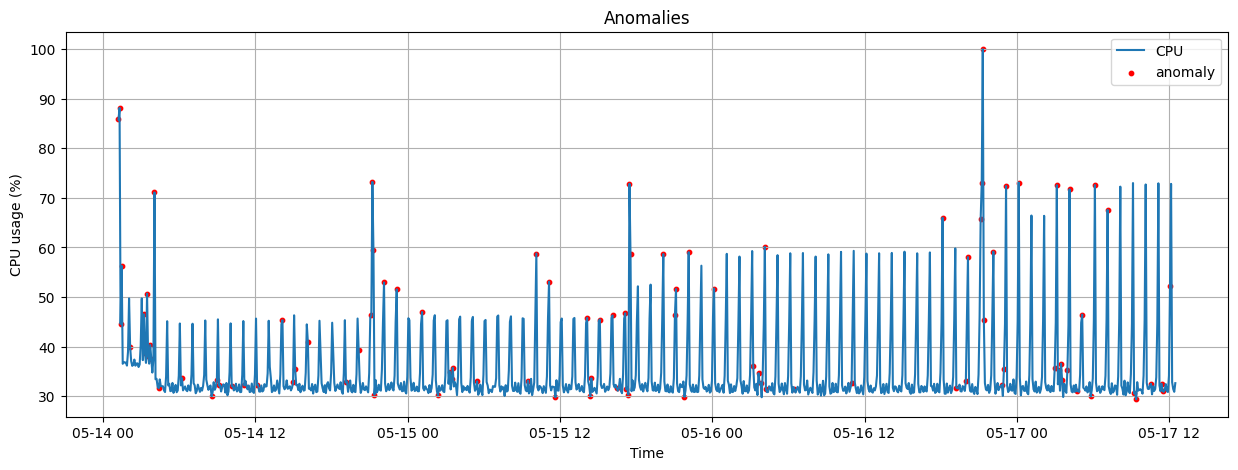

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df_resid['is_anomaly'], 'timestamp'], 
            y = df.loc[df_resid['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

#### Local Outlier Factor 

In [23]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
df_resid['is_anomaly'] = lof.fit_predict(df_resid.loc[:, ['residuals']]) == -1
df_resid['is_anomaly'].value_counts()

is_anomaly
False    964
True      36
Name: count, dtype: int64

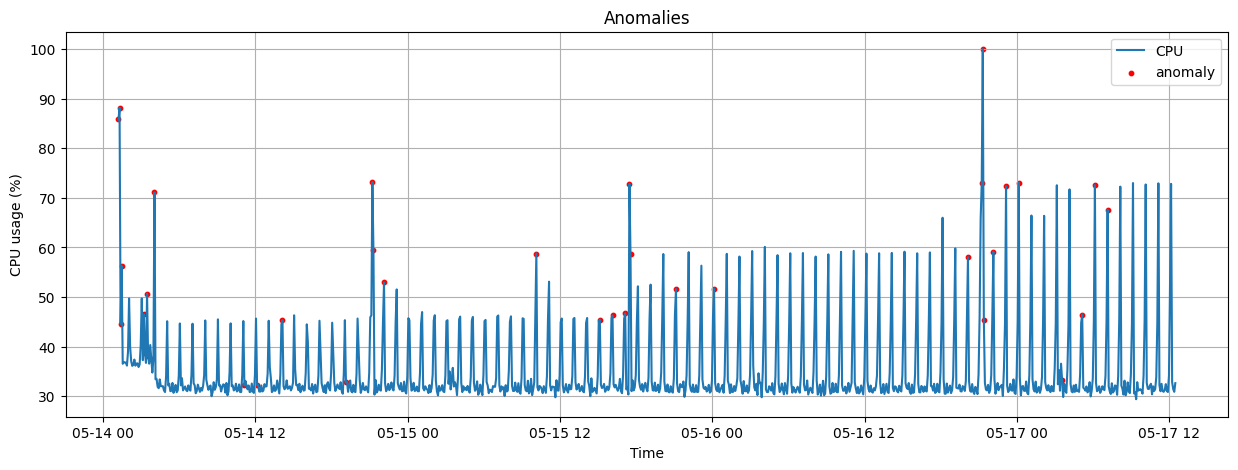

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], label='CPU')
plt.scatter(x = df.loc[df_resid['is_anomaly'], 'timestamp'], 
            y = df.loc[df_resid['is_anomaly'], 'value'],
            color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

### (S)ARIMA models

In [25]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['value'], order=(2,1,1), seasonal_order=(1,0,0,12)).fit()
# model = ARIMA(df['value'], order=(1,1,1)).fit()
model.params

ar.L1        0.551811
ar.L2       -0.121108
ma.L1       -0.999858
ar.S.L12     0.803183
sigma2      23.875265
dtype: float64

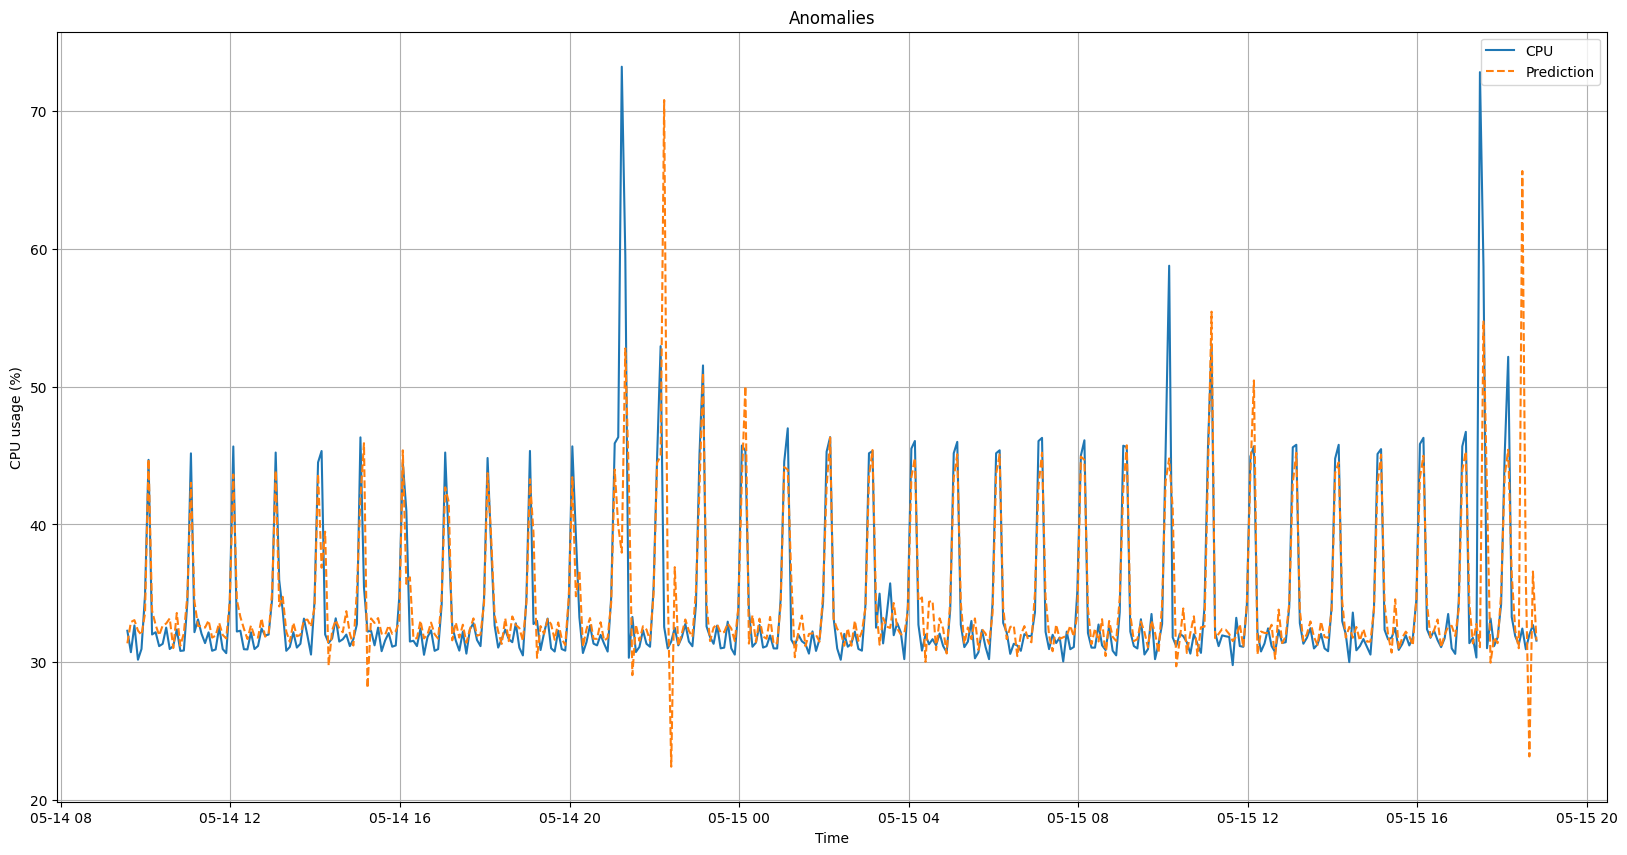

In [26]:
df['arima'] = model.predict()
plt.figure(figsize=(20, 10))
plt.plot(df['timestamp'][100:500], df['value'][100:500], label='CPU')
plt.plot(df['timestamp'][100:500], df['arima'][100:500], label='Prediction', linestyle='--')
# plt.scatter(x = df.loc[df_resid['is_anomaly'], 'timestamp'], 
#             y = df.loc[df_resid['is_anomaly'], 'value'],
#             color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)

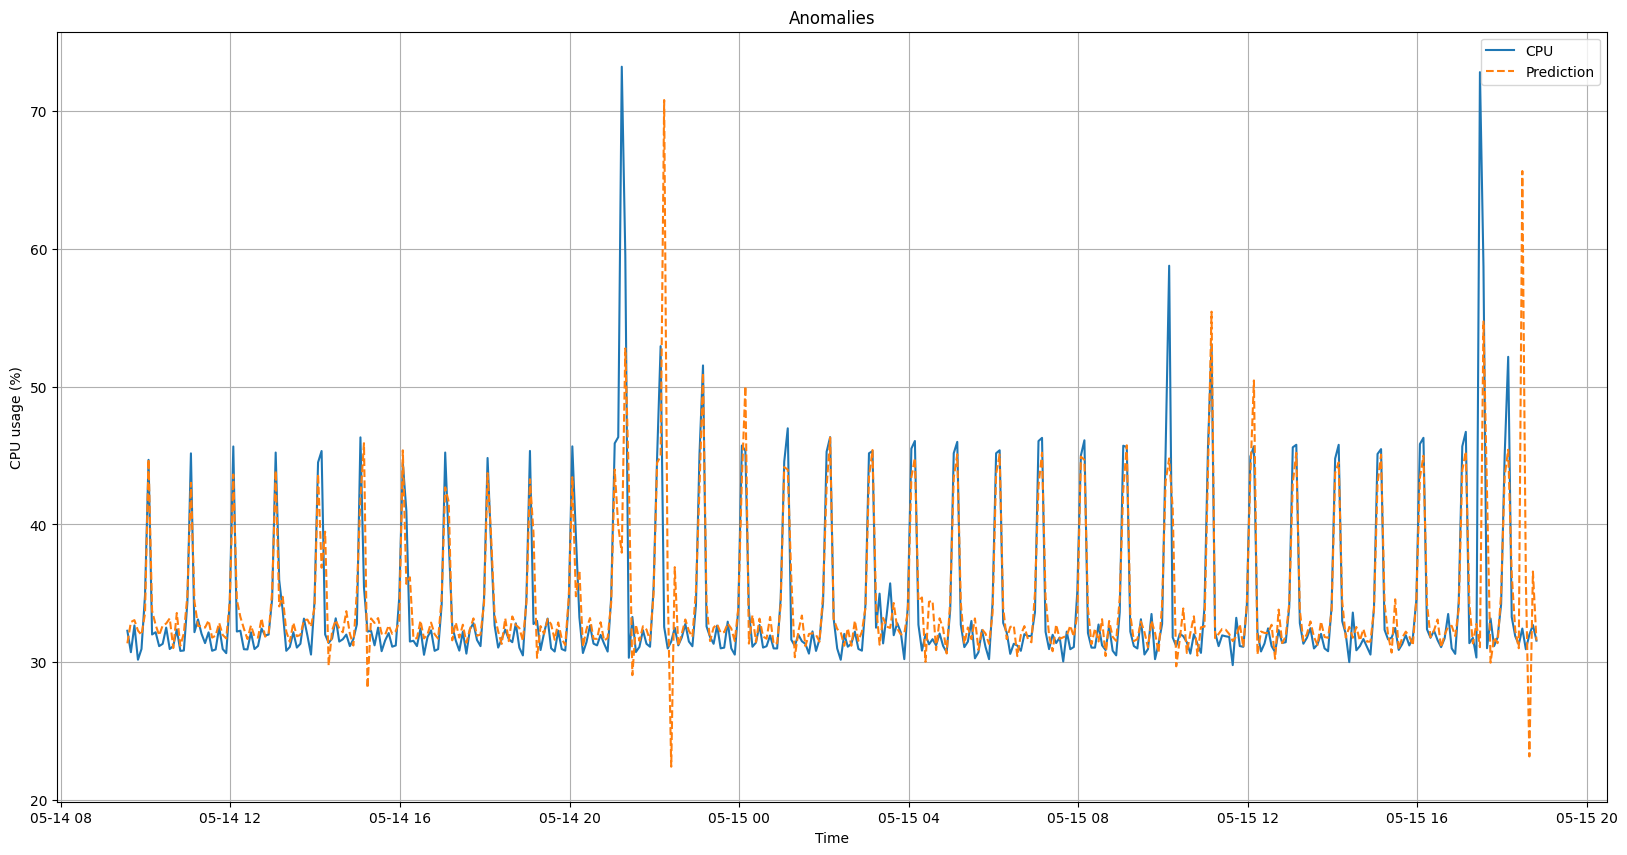

In [27]:
df['arima'] = model.predict()
plt.figure(figsize=(20, 10))
plt.plot(df['timestamp'][100:500], df['value'][100:500], label='CPU')
plt.plot(df['timestamp'][100:500], df['arima'][100:500], label='Prediction', linestyle='--')
# plt.scatter(x = df.loc[df_resid['is_anomaly'], 'timestamp'], 
#             y = df.loc[df_resid['is_anomaly'], 'value'],
#             color = 'red', label='anomaly', s=10)
plt.xlabel('Time')
plt.ylabel('CPU usage (%)')
plt.title('Anomalies')
plt.legend()
plt.grid(True)